# Exploring Astronaut Activities in SQL
## By: Vatsal Vinay Parikh

[Source of the data](https://www.kaggle.com/datasets/alexandrepetit881234/astronauts-extra-vehicular-activities)

## Exploring our data
Let's start by looking at the table we will be working with.

In [5]:
-- Explore the data in the table
SELECT *
FROM evas
LIMIT 5;

,date,country,vehicle,duration,crew,purpose,year,program
0,1965-06-03,USA,Gemini IV,36,Ed White,First U.S. EVA. Used HHMU and took photos. G...,1965,Gemini
1,1966-03-16,USA,Gemini VIII,0,David Scott,HHMU EVA cancelled before starting by stuck on...,1966,Gemini
2,1966-06-05,USA,Gemini IX-A,127,Eugene Cernan,"Inadequate restraints, stiff 25ft umbilical an...",1966,Gemini
3,1966-07-19,USA,Gemini X,50,Mike Collins,Standup EVA. UV photos of stars. Ended by ey...,1966,Gemini
4,1966-07-20,USA,Gemini X,39,Mike Collins,Retrieved MMOD experiment from docked Agena. ...,1966,Gemini


Let's inspect the `purpose` column in greater detail.

In [6]:
SElECT purpose 
FROM evas

,purpose
0,First U.S. EVA. Used HHMU and took photos. G...
1,HHMU EVA cancelled before starting by stuck on...
2,"Inadequate restraints, stiff 25ft umbilical an..."
3,Standup EVA. UV photos of stars. Ended by ey...
4,Retrieved MMOD experiment from docked Agena. ...
...,...
370,1 hr late start due to airlock valve. Relocat...
371,"Installed plasma experiment/cables/probes, rep..."
372,Power cable clamps installed and Kurs tested i...
373,"Â Installed VINOSLIVOST experiment on MRM2, 2..."


## What are the most common types of EVAs?
Let's start to get a rough idea of the most popular types of EVAs astronauts take by using [`CASE` expressions](https://www.postgresql.org/docs/current/functions-conditional.html).

In [13]:
SELECT 
	purpose,
	CASE WHEN purpose ILIKE '%photos%' THEN 1 ELSE 0 END as photography,
	CASE WHEN purpose ILIKE '%collect' THEN 1 ELSE 0 END as collection,
	CASE WHEN purpose ILIKE '%construct' OR purpose ILIKE '%install%' OR purpose ILIKE '%assembl%' THEN 1 ELSE 0 END as installation,
	CASE WHEN purpose ILIKE '%replace' OR purpose ILIKE '%fix%' OR purpose ILIKE '%repair%' OR purpose ILIKE '%servic%' THEN 1 ELSE 0 END as repair
FROM evas

,purpose,photography,collection,installation,repair
0,First U.S. EVA. Used HHMU and took photos. G...,1,0,0,0
1,HHMU EVA cancelled before starting by stuck on...,0,0,0,0
2,"Inadequate restraints, stiff 25ft umbilical an...",0,0,0,0
3,Standup EVA. UV photos of stars. Ended by ey...,1,0,0,0
4,Retrieved MMOD experiment from docked Agena. ...,0,0,0,0
...,...,...,...,...,...
370,1 hr late start due to airlock valve. Relocat...,0,0,1,1
371,"Installed plasma experiment/cables/probes, rep...",0,0,1,0
372,Power cable clamps installed and Kurs tested i...,0,0,1,0
373,"Â Installed VINOSLIVOST experiment on MRM2, 2...",0,0,1,0


We are now ready to build this into a final query!

In [17]:
WITH purposes AS(	
	SELECT 
		purpose,
		CASE WHEN purpose ILIKE '%photos%' THEN 1 ELSE 0 END as photography,
		CASE WHEN purpose ILIKE '%collect%' THEN 1 ELSE 0 END as collection,
		CASE WHEN purpose ILIKE '%construct' OR purpose ILIKE '%install%' OR purpose ILIKE '%assembl%' THEN 1 ELSE 0 END as installation,
		CASE WHEN purpose ILIKE '%replace' OR purpose ILIKE '%fix%' OR purpose ILIKE '%repair%' OR purpose ILIKE '%servic%' THEN 1 ELSE 0 END as repair
	FROM evas
)

SELECT 
	SUM(photography) AS count,
	'photography' AS type
FROM purposes
UNION
SELECT 
	SUM(collection) AS count,
	'collection' AS type
FROM purposes
UNION
SELECT 
	SUM(installation) AS count,
	'installation' AS type
FROM purposes
UNION
SELECT 
	SUM(repair) AS count,
	'repair' AS type
FROM purposes
ORDER BY count

,count,type
0,13,photography
1,16,collection
2,77,repair
3,189,installation


,count,type
0,13,photography
1,16,collection
2,77,repair
3,189,installation


## How much material has been extracted from EVAs?
Skimming through the `purpose` column, we also saw numerous references to extracting rock/dust or geological material. In this case, it will be difficult to extract the total quantity across the columns. Regular expressions to the rescue!

We will define a pattern to extract the total pounds extracted per EVA, and then sum them up. Let's first do a sense check of the data.

In [23]:
SELECT 
	purpose
FROM evas
WHERE purpose ILIKE '%geologic%' OR purpose ILIKE '%rock%'

,purpose
0,First to walk on the moon. Some trouble getti...
1,Collected 75.6 lb of geologic material. ALSEP...
2,Collected 94.4 lb of geologic material. ALSEP...
3,Collected 169 lb of geologic material. ALSEP ...
4,Collected 208 lb of rock/dust (41lb this day)....
5,Collected 82 lb of rock/dust. Drove rover 11.5 km
6,Collected 90 lb of rock/dust. Drove rover 27....
7,Collected 243 lb of geologic material. ALSEP ...


Okay, we now know that the format of the pounds extracted is always `number lbs of rock/geologic`. We can construct a pattern to detect this and extract the number!

To do so, we will make use of:
- `\d+` to match one or more digits.
- `\.?` to match zero or more periods.\
- `*` to match zero or more digits following the optional decimal place.
- `()` to specify we only want the digits.
- `\s` to match the whitespace (i.e., spaces).
- `[]` and `|` to specify we either want to match "geologic" or "rock".

Let's put this into action, using [`SUBSTRING()`](https://www.postgresql.org/docs/9.1/functions-string.html) to extract our pattern!

In [29]:
SELECT
	purpose,
	SUBSTRING(purpose, '(\d+\.?\d*) lb of ((rock)|(geologic))') AS weight
FROM evas

,purpose,weight
0,First U.S. EVA. Used HHMU and took photos. G...,NaN
1,HHMU EVA cancelled before starting by stuck on...,NaN
2,"Inadequate restraints, stiff 25ft umbilical an...",NaN
3,Standup EVA. UV photos of stars. Ended by ey...,NaN
4,Retrieved MMOD experiment from docked Agena. ...,NaN
...,...,...
370,1 hr late start due to airlock valve. Relocat...,NaN
371,"Installed plasma experiment/cables/probes, rep...",NaN
372,Power cable clamps installed and Kurs tested i...,NaN
373,"Â Installed VINOSLIVOST experiment on MRM2, 2...",NaN


Now we can use a CTE to calculate the total amount!

In [30]:
WITH weights AS (
	SELECT
		purpose,
		SUBSTRING(purpose, '(\d+\.?\d*) lb of ((rock)|(geologic))') AS weight
	FROM evas
)

SELECT SUM(weight::NUMERIC)
FROM weights

,sum
0,1008.3


## Which astronauts have the most time in EVAs?
We also have information on how much time each EVA took, as well as the astronauts who participated. Let's use this information to try and calculate totals for each astronaut!

First let's see what the maximum count of astronauts in an EVA has been by [splitting](https://www.postgresql.org/docs/9.1/functions-string.html) the `crew` column. We can also use `TRIM()` to remove any extra whitespace from the column.

In [35]:
SELECT 
	crew,
	SPLIT_PART(crew, ',', 1) AS first_astronaut
FROM evas

,crew,first_astronaut
0,Ed White,Ed White
1,David Scott,David Scott
2,Eugene Cernan,Eugene Cernan
3,Mike Collins,Mike Collins
4,Mike Collins,Mike Collins
...,...,...
370,"Gennady Padalka, Yuri Malenchenko",Gennady Padalka
371,"Pavel Vinogradov, Roman Romanenko",Pavel Vinogradov
372,"Fyodor Yurchikhin, Alexander Misurkin",Fyodor Yurchikhin
373,"Fyodor Yurchikhin, Alexander Misurkin",Fyodor Yurchikhin


In [37]:
SELECT 
	crew,
	SPLIT_PART(crew, ',', 3) AS third_astronaut
FROM evas
WHERE SPLIT_PART(crew, ',', 3) != ''

,crew,third_astronaut
0,"Paul Weitz, Joe Kerwin, Pete Conrad",Pete Conrad


Now we know how we can extract the time for each astronaut! Let's create a CTE we can then use to piece together `duration` information for each astronaut.

In [38]:
WITH astronauts_split AS (
	SELECT 
		crew,
 		SPLIT_PART(crew, ',', 1) AS first_astronaut,
		SPLIT_PART(crew, ',', 2) AS second_astronaut,
 		SPLIT_PART(crew, ',', 3) AS third_astronaut,
		duration
	FROM evas
)

SELECT *
FROM astronauts_split

,crew,first_astronaut,second_astronaut,third_astronaut,duration
0,Ed White,Ed White,,,36
1,David Scott,David Scott,,,0
2,Eugene Cernan,Eugene Cernan,,,127
3,Mike Collins,Mike Collins,,,50
4,Mike Collins,Mike Collins,,,39
...,...,...,...,...,...
370,"Gennady Padalka, Yuri Malenchenko",Gennady Padalka,Yuri Malenchenko,,351
371,"Pavel Vinogradov, Roman Romanenko",Pavel Vinogradov,Roman Romanenko,,398
372,"Fyodor Yurchikhin, Alexander Misurkin",Fyodor Yurchikhin,Alexander Misurkin,,394
373,"Fyodor Yurchikhin, Alexander Misurkin",Fyodor Yurchikhin,Alexander Misurkin,,449


Now it's just a matter of splitting apart this table and appending each set of results to one table.

In [39]:
WITH astronauts_split AS (
	SELECT 
		crew,
 		SPLIT_PART(crew, ',', 1) AS first_astronaut,
		SPLIT_PART(crew, ',', 2) AS second_astronaut,
 		SPLIT_PART(crew, ',', 3) AS third_astronaut,
		duration
	FROM evas
),

astronaut_duration AS (
	SELECT 
		first_astronaut AS astronaut,
		duration
	FROM astronauts_split
	WHERE first_astronaut != ''
	UNION ALL
	SELECT 
		second_astronaut AS astronaut,
		duration
	FROM astronauts_split
	WHERE second_astronaut != ''
	UNION ALL
	SELECT 
		third_astronaut AS astronaut,
		duration
	FROM astronauts_split
	WHERE third_astronaut != ''
)

SELECT 
	astronaut,
	SUM(duration) AS total_duration
FROM astronaut_duration
GROUP BY astronaut
ORDER BY total_duration DESC
LIMIT 10

,astronaut,total_duration
0,Jerry Ross,3501
1,Anatoly Solovyev,3086
2,Scott Parazynski,2825
3,Nikola Budarin,2672
4,John Grunsfeld,2527
5,Mike Lopez-Alegria,2501
6,Mike Fincke,2472
7,Dan Tani,2351
8,Victor Afanasyev,2314
9,Rick Mastracchio,2311


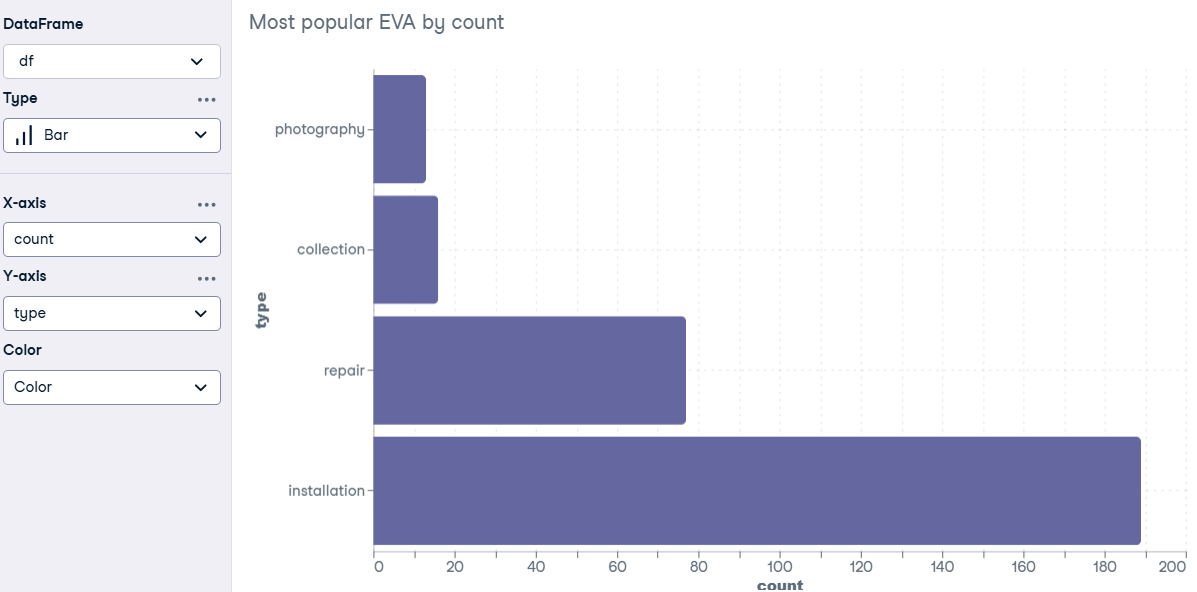

## What is the cumulative amount of time spent in EVAs over time?
Finally, let's take a look at the cumulative time spent in EVAs by year and space program. To do so, we will need to use a [window function](https://www.postgresql.org/docs/current/tutorial-window.html) in combination with a subquery.

In [42]:
SELECT 
	year,
	program,
	SUM(duration) AS DURATION
FROM evas
GROUP BY year,program
ORDER BY year, program

,year,program,duration
0,1965,Gemini,36
1,1965,Voskhod,12
2,1966,Gemini,720
3,1969,Apollo,707
4,1969,Soyuz,37
...,...,...,...
63,2010,Space Shuttle,3591
64,2011,ISS,1388
65,2011,Space Shuttle,2492
66,2012,ISS,2009


In [45]:
SELECT 
	TO_DATE(year::TEXT, 'YYYY') AS year,
	program,
	duration,
	SUM(duration) OVER(PARTITION BY program ORDER BY year) AS cumulative_distribution
FROM(
	SELECT 
		year,
		program,
		SUM(duration) AS DURATION
	FROM evas
	GROUP BY year,program
	ORDER BY year, program
) AS sub
ORDER BY year,program

,year,program,duration,cumulative_distribution
0,1965-01-01 00:00:00+00:00,Gemini,36,36
1,1965-01-01 00:00:00+00:00,Voskhod,12,12
2,1966-01-01 00:00:00+00:00,Gemini,720,756
3,1969-01-01 00:00:00+00:00,Apollo,707,707
4,1969-01-01 00:00:00+00:00,Soyuz,37,37
...,...,...,...,...
63,2010-01-01 00:00:00+00:00,Space Shuttle,3591,61140
64,2011-01-01 00:00:00+00:00,ISS,1388,17901
65,2011-01-01 00:00:00+00:00,Space Shuttle,2492,63632
66,2012-01-01 00:00:00+00:00,ISS,2009,19910


,year,program,duration,cumulative_distribution
0,1965-01-01 00:00:00+00:00,Gemini,36,36
1,1965-01-01 00:00:00+00:00,Voskhod,12,12
2,1966-01-01 00:00:00+00:00,Gemini,720,756
3,1969-01-01 00:00:00+00:00,Apollo,707,707
4,1969-01-01 00:00:00+00:00,Soyuz,37,37
...,...,...,...,...
63,2010-01-01 00:00:00+00:00,Space Shuttle,3591,61140
64,2011-01-01 00:00:00+00:00,ISS,1388,17901
65,2011-01-01 00:00:00+00:00,Space Shuttle,2492,63632
66,2012-01-01 00:00:00+00:00,ISS,2009,19910


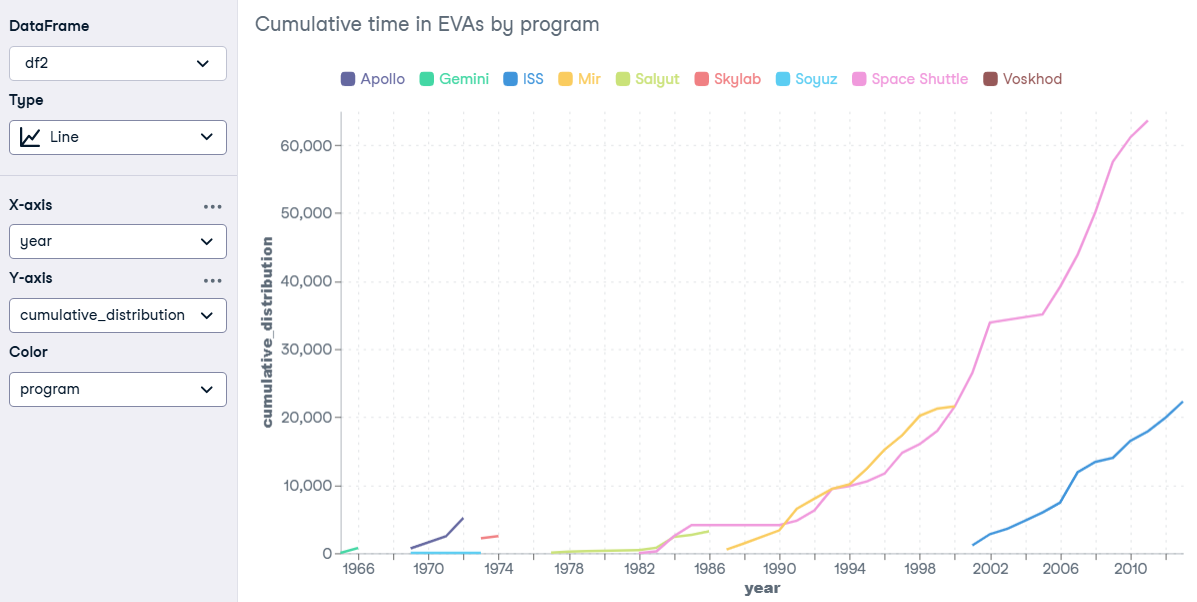